In [1]:
__version__ = '20180808' #Revised version
#__version__ = '20180806' #Launched version

## Imports and setup
We import all modules required for this notebook

In [2]:
# std. lib
import sys
sys.path.append('../../../hypercat/hypercat/')

# 3rd party
import pylab as plt
import numpy as np

# hypercat
import hypercat
import plotting
import bigfileops as bfo
import ioops
import psf
import obsmodes

In [3]:
###----------------HDF file dir-------------------###
#hdffile = '/YOUR_HDF_FILEPATH/hypercat_20180417.hdf5'  #For the public version
hdffile = '/Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5' #Kohei's local dir
#hdffile = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20180417.hdf5'

# Imaging 'Observation'
In this notebook we will describe how to obtain the 'observed' image based on the actual set of telescope/insrument

In [4]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='minimal')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (693.51 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, 13.000, 14.000, 15.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 -

In [14]:
sig, i, Y, N, q, tv, wave = 15, 45, 18, 4, 0.01, 90, 10.  # example parameters, here e.g. for NGC1068 from Lopez-Rodriguez+2018
vec = (sig, i, Y, N, q, tv, wave) #The order of the parameter set is also important...
#list of the parameters
Lbol = '1.6e45 erg/s' #the unit Lsun is also available. Is is used only for calculating dust sublimation radius
D = '14.4 Mpc'
PA = '42 deg' #PA is optional
objectname = 'ngc1068' #objectname is optional

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Plotting panel (0,0)


(<Figure size 288x288 with 2 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0xc97b65c5f8>]],
       dtype=object))

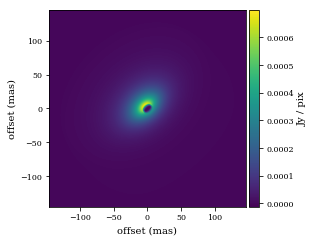

In [15]:
ngc1068 = hypercat.Source(imgcube,luminosity=Lbol,distance=D,pa=PA,objectname=objectname)
sky = ngc1068(vec,total_flux_density='1. Jy')
plotting.multiplot(sky)

# Imaging

Let's get the Pupil and PSF from a telescope

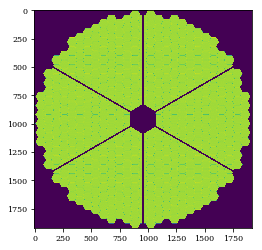

In [16]:
Pupil, Pupilheader=psf.getPupil(psfdict={'telescope':'TMT'})

plt.imshow(Pupil)

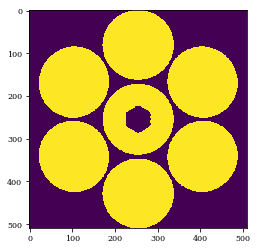

In [17]:
### - Pupil Mode
psfdict = {'psfmode':'pupil',\
           'telescope':'GMT',\
           'wavelength':'10 micron',\
           'pixelscale_detector':'Nyquist'}
Pupil, Pupilheader = psf.getPupil(psfdict)
plt.imshow(Pupil)

Pixel scale in PSF image is:  77.66998423180651  mas per pixel


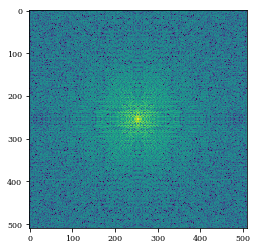

In [18]:
# get PSF
psfdict = {'psfmode':'pupil',\
           'telescope':'GMT',\
           'wavelength':'10 micron',\
           'pixelscale_detector':'Nyquist'}
PSF = psf.getPSF(psfdict)
plt.imshow(np.log10(PSF.I),vmin=-6,vmax=-1)

## NOTE: Plot the PSF in arcsecs. PSF has the pixelscale, FOV information.

In [19]:
#Synthetic obervations
psfdict = {'psfmode':'pupil',\
           'telescope':'ELT',\
           'wavelength':'10 micron',\
           'pixelscale_detector':'Nyquist'}
#Create the Instrument for the observations
obs = obsmodes.Imaging(psfdict)
#perform the observations
ngc1068_obs, PSF, PSF_resampled = obs.observe(sky,psfdict=psfdict)
#deconvolve observations
ngc1068_deconv = PSF_resampled.deconvolve(ngc1068_obs)

Pixel scale in PSF image is:  51.50190143782713  mas per pixel
Pixel scale in PSF image is:  51.50190143782713  mas per pixel
self.PSF: Computed pixelscale from pupil =  51.50190143782713 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20896 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (25.751 mas) was slightly adjusted due to discretization (now 26.464 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (25.751 mas) was slightly adjusted due to discretization (now 28.6122 mas). This is to preserve sizes on the sky.


/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr

Coordinates for source 'ngc1068' resolved. WCS created.


/Users/motigomeman/miniconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [20]:
obs.observe(sky,psfdict=psfdict)

Pixel scale in PSF image is:  51.50190143782713  mas per pixel
self.PSF: Computed pixelscale from pupil =  51.50190143782713 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20896 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (25.751 mas) was slightly adjusted due to discretization (now 26.464 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (25.751 mas) was slightly adjusted due to discretization (now 28.6122 mas). This is to preserve sizes on the sky.


/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr

Coordinates for source 'ngc1068' resolved. WCS created.


(<imageops.Image at 0xc97b63f080>,
 <psf.PSF at 0xc97bc7a3c8>)

In [21]:
print(sky.npix, PSF.npix)
print(sky.pixelscale, PSF.pixelscale)
ngc1068_obs.npix, PSF_resampled.npix
ngc1068_obs.I.shape, PSF_resampled.I.shape

241 213
1.2079010905076883 mas 1.208964822484205 mas


((11, 11), (9, 9))

Text(0.5,1,'Deconvolved observations')

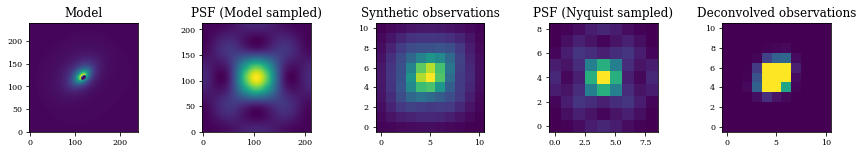

In [22]:
fig, axs = plt.subplots(1,5,figsize=(15,2))
ax = axs.flatten()

ax[0].imshow(sky.I,origin='lower')
ax[1].imshow(PSF.I,origin='lower')
ax[2].imshow(ngc1068_obs.I,origin='lower')
ax[3].imshow(PSF_resampled.I,origin='lower')
ax[4].imshow(ngc1068_deconv,origin='lower')

#titles
ax[0].set_title('Model')
ax[1].set_title('PSF (Model sampled)')
ax[2].set_title('Synthetic observations')
ax[3].set_title('PSF (Nyquist sampled)')
ax[4].set_title('Deconvolved observations')

Pixel scale in PSF image is:  77.66998423180651  mas per pixel
self.PSF: Computed pixelscale from pupil =  77.66998423180651 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20731 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (38.835 mas) was slightly adjusted due to discretization (now 41.5863 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (38.835 mas) was slightly adjusted due to discretization (now 46.602 mas). This is to preserve sizes on the sky.


/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/Users/motigomeman/miniconda3/lib/python3.6/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr

Coordinates for source 'ngc1068' resolved. WCS created.


Text(0.5,1,'PSF (Nyquist sampled)')

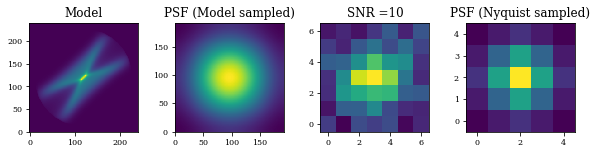

In [14]:
#Adding noise to the observations
SNR = 10
ngc1068_obs, PSF, PSF_resampled = obs.observe(sky,snr=SNR,psfdict=psfdict)

#Plotting
fig, axs = plt.subplots(1,4,figsize=(10,2))
ax = axs.flatten()

ax[0].imshow(sky.I,origin='lower')
ax[1].imshow(PSF.I,origin='lower')
ax[2].imshow(ngc1068_obs.I,origin='lower')
ax[3].imshow(PSF_resampled.I,origin='lower')

#titles
ax[0].set_title('Model')
ax[1].set_title('PSF (Model sampled)')
ax[2].set_title('SNR ='+np.str(SNR))
ax[3].set_title('PSF (Nyquist sampled)')